# Introduction
In the last notebook we saw that MLPs with multiple layers are pretty good at coming up with names. In this notebook we dive deep into the network to understand what is going on and how to do diagnostics.

We will go though the following:

*
*


We dive into some of the internals of MLPs with multiple layers and scrutinize the statistics of the forward pass activations, backward pass gradients, and some of the pitfalls when they are improperly scaled. We also look at the typical diagnostic tools and visualizations you'd want to use to understand the health of your deep network. We learn why training deep neural nets can be fragile and introduce the first modern innovation that made doing so much easier: Batch Normalization. Residual connections and the Adam optimizer remain notable todos for later video.

# Libraries

In [2]:
%matplotlib inline
%config IPCompleter.use_jedi=False

In [8]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Data
This step is pretty much equiviant of that in the previous notebook, so we will not go into depth on how the dataset is created.

### Reading the Data

In [4]:
# Reading names into a list
with open('../../data/names.txt', 'r') as f:
    names = f.readlines()
    names = [name.strip() for name in names]

### Creating Vocabulary

In [5]:
# Building the vocabulary (character to/from index)
chars = sorted(list(set(''.join(names))))
chr_to_idx = {s:i+1 for i,s in enumerate(chars)}; print(chr_to_idx)
chr_to_idx['.'] = 0
idx_to_chr = {i:s for s,i in chr_to_idx.items()}; print(idx_to_chr)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Preparing Dataset

In [6]:
def build_dataset(words: list, block_size: int = 3, verbose: bool = False) -> tuple:
    """
    Description:
        Take a list of words and creates Xs and Ys give
        a block size. E.g. block_size=3 for emma would 
        result in:
            ... ---> e  
            ..e ---> m  
            .em ---> m  
            emm ---> a  
            mma ---> . 
        Stored in a (n, 3) tensor
    Inputs:
        words: List of words
        block_size: The context window
        verbose: Where to print the outputs
    Ouputs:
        A (n, block_size) tensor with Xs
        A (n) tensor with Ys
    """
    X, Y = [], []
    for word in words:
        if verbose:
            print(word)
        context = [0] * block_size
        for char in word + '.':
            idx = chr_to_idx[char]
            X.append(context)
            Y.append(idx)
            if verbose:
                print(''.join(idx_to_chr[i] for i in context), idx_to_chr[idx])
            context = context[1:] + [idx]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    
    return X, Y

In [9]:
# Putting names in random order
random.shuffle(names)

# Creating split indices
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))

In [11]:
# Building training, validation and test sets
Xtr, Ytr = build_dataset(names[:n1]); print(Ytr.size())
Xval, Yval = build_dataset(names[n1:n2]); print(Yval.size())
Xtest, Ytest = build_dataset(names[n2:]); print(Ytest.size())

torch.Size([182509])
torch.Size([22925])
torch.Size([22712])


# Building Network
We build a similar MLP to that in the previous notebook.

In [46]:
n_embd = 10
n_hidden = 200
block_size = 3
vocab_size = len(chr_to_idx)

# Lookup table
C = torch.randn([vocab_size, n_embd])

# Weights and biases
W1 = torch.randn([n_embd * block_size, n_hidden])
b1 = torch.randn([n_hidden])
W2 = torch.randn([n_hidden, vocab_size])
b2 = torch.randn([vocab_size])

# Placing parameters in list
parameters = [C, W1, b1, W2, b2]

# Enabling gradients
for p in parameters:
    p.requires_grad = True
print("Number of parameters: " + str(sum(p.nelement() for p in parameters)))

Number of parameters: 11897


# Training
We use the same training loop as in the previous notebook. We have, however, refactored a bit, and defined a method for calculating the loss without messing with the gradients.

In [50]:
@torch.no_grad() # Decorator disables gradient tracking
def split_loss(split: str = 'train', print_loss: bool = False) -> None:
    """
    Description:
        Prints the loss of a chosen split
    Inputs:
        split: train, valid, or test
    """
    x,y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y) 
    
    if print_loss:
        print(split, loss.item())
    else :
        return loss.item()

In [51]:
losses = {"Train": [], "Val": []}

In [58]:
epochs = 100000
batch_size = 64
lr = 0.1

for epoch in range(epochs):
    
    # Minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    h_preactiv = emb_cat @ W1 + b1
    h = torch.tanh(h_preactiv)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)    
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    ## Update
    if epoch < 30000:
        for p in parameters:
            p.data += -lr * p.grad
    elif epoch < 60000:
        for p in parameters:
            p.data += -lr * 0.1 * p.grad
    else:
        for p in parameters:
            p.data += -lr * 0.01 * p.grad        
        
    # Tracking stats
    losses["Train"].append(loss.item())
    #losses["Val"].append(split_loss("valid"))

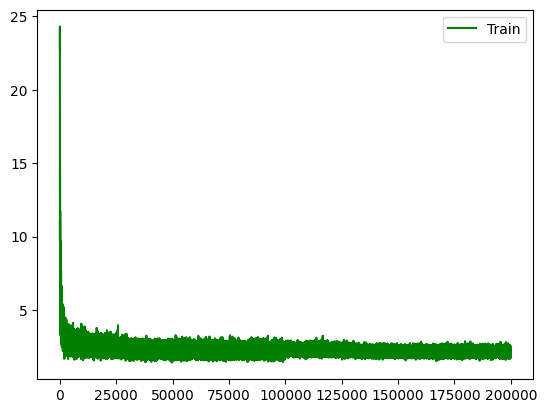

In [59]:
# Plotting training and validation losses
xs = list(range(1, len(losses["Train"])+1))
plt.plot(xs, losses["Train"], label = "Train", color="green")
#plt.plot(xs, losses["Val"], label = "Valid", color="red")
plt.legend()
plt.show()

In [60]:
split_loss("train", print_loss=True)
split_loss("valid", print_loss=True)

train 2.1410491466522217
valid 2.1836094856262207


# Generating Names

In [61]:
number_of_names = 20

for _ in range(number_of_names):
    
    char_idx = []
    context = [0] * block_size # Initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # Embeddings for context
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [idx]
        char_idx.append(idx)
        if idx == 0:
            break
    
    print(''.join(idx_to_chr[char_idx] for char_idx in char_idx))

chana.
mellena.
bolda.
tersipzon.
daja.
raevanmalyn.
abnoea.
ann.
mir.
ala.
kayliah.
ashalick.
lafidai.
mauliia.
kari.
carystynn.
ros.
rymi.
creniah.
tyleighorghank.


In [ ]:
# https://www.youtube.com/watch?v=P6sfmUTpUmc